#Installs

In [ ]:
pip install lifelines

In [ ]:
pip install ace_tools

In [ ]:
pip install SurvivalEVAL

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 50.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 31.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 37.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 86.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

#Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from lifelines import WeibullAFTFitter, WeibullFitter, KaplanMeierFitter
from sklearn.model_selection import train_test_split
from lifelines.utils import k_fold_cross_validation, concordance_index
from SurvivalEVAL.Evaluator import LifelinesEvaluator
import pickle

## Load the Data

In [ ]:
# Load the data
#data = pd.read_csv(r"C:\Users\lhumbert\OneDrive - Inside MD Anderson\TTE-ORN-shared_new\final_analysis\tte-orn-raw-PHI_LHV_updated_May2024_AFT_SK.csv")
file_path = "/content/drive/My Drive/Colab Notebooks/ORN TTE/TTE_ORN_data_Figshare.csv"
data = pd.read_csv(file_path)

# Prepare the model data
data['Gender_binary'] = data['Gender'].map({'Male': 1, 'Female': 0})
model_data = data[['ORN status', 'Time to event', 'Pre-RT dental extractions', 'D25%', 'Gender_binary']].copy()


pd.set_option('display.max_columns', None)
#model_data

print(model_data.head())

   ORN status  Time to event  Pre-RT dental extractions   D25%  Gender_binary
0           0         117.40                          0  57.80              1
1           0          45.40                          1  56.14              1
2           0         117.50                          0  56.78              1
3           0          46.00                          0  53.48              1
4           1           5.45                          1  60.96              0


#Frequency and nonparametric plots

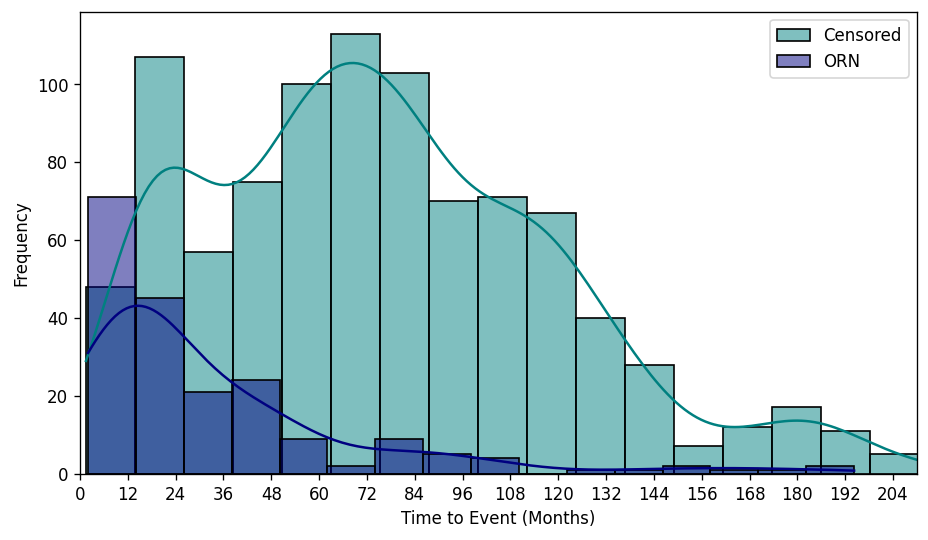

In [ ]:

# Distribution of Time to Event (tte) for orn_status=1 and orn_status=0
plt.figure(figsize=(9, 5), dpi=120)  # Setting figure size and resolution

sns.histplot(model_data[model_data['ORN status'] == 0]['Time to event'], color="teal", label='Censored', kde=True)
sns.histplot(model_data[model_data['ORN status'] == 1]['Time to event'], color="navy", label='ORN', kde=True)
#plt.title('Distribution of Time to Event (TTE) by ORN Status')
plt.xlabel('Time to Event (Months)')
plt.ylabel('Frequency')
xticks = list(range(0, 240, 12))  # Generate ticks from 0 to 220, stepping by 20
#xticks.append(210)  # Ensure 60 is included
xticks = sorted(set(xticks))  # Remove duplicates and sort
plt.xticks(xticks)  # Apply custom ticks
plt.xlim([0, 210])

plt.legend()
plt.show()

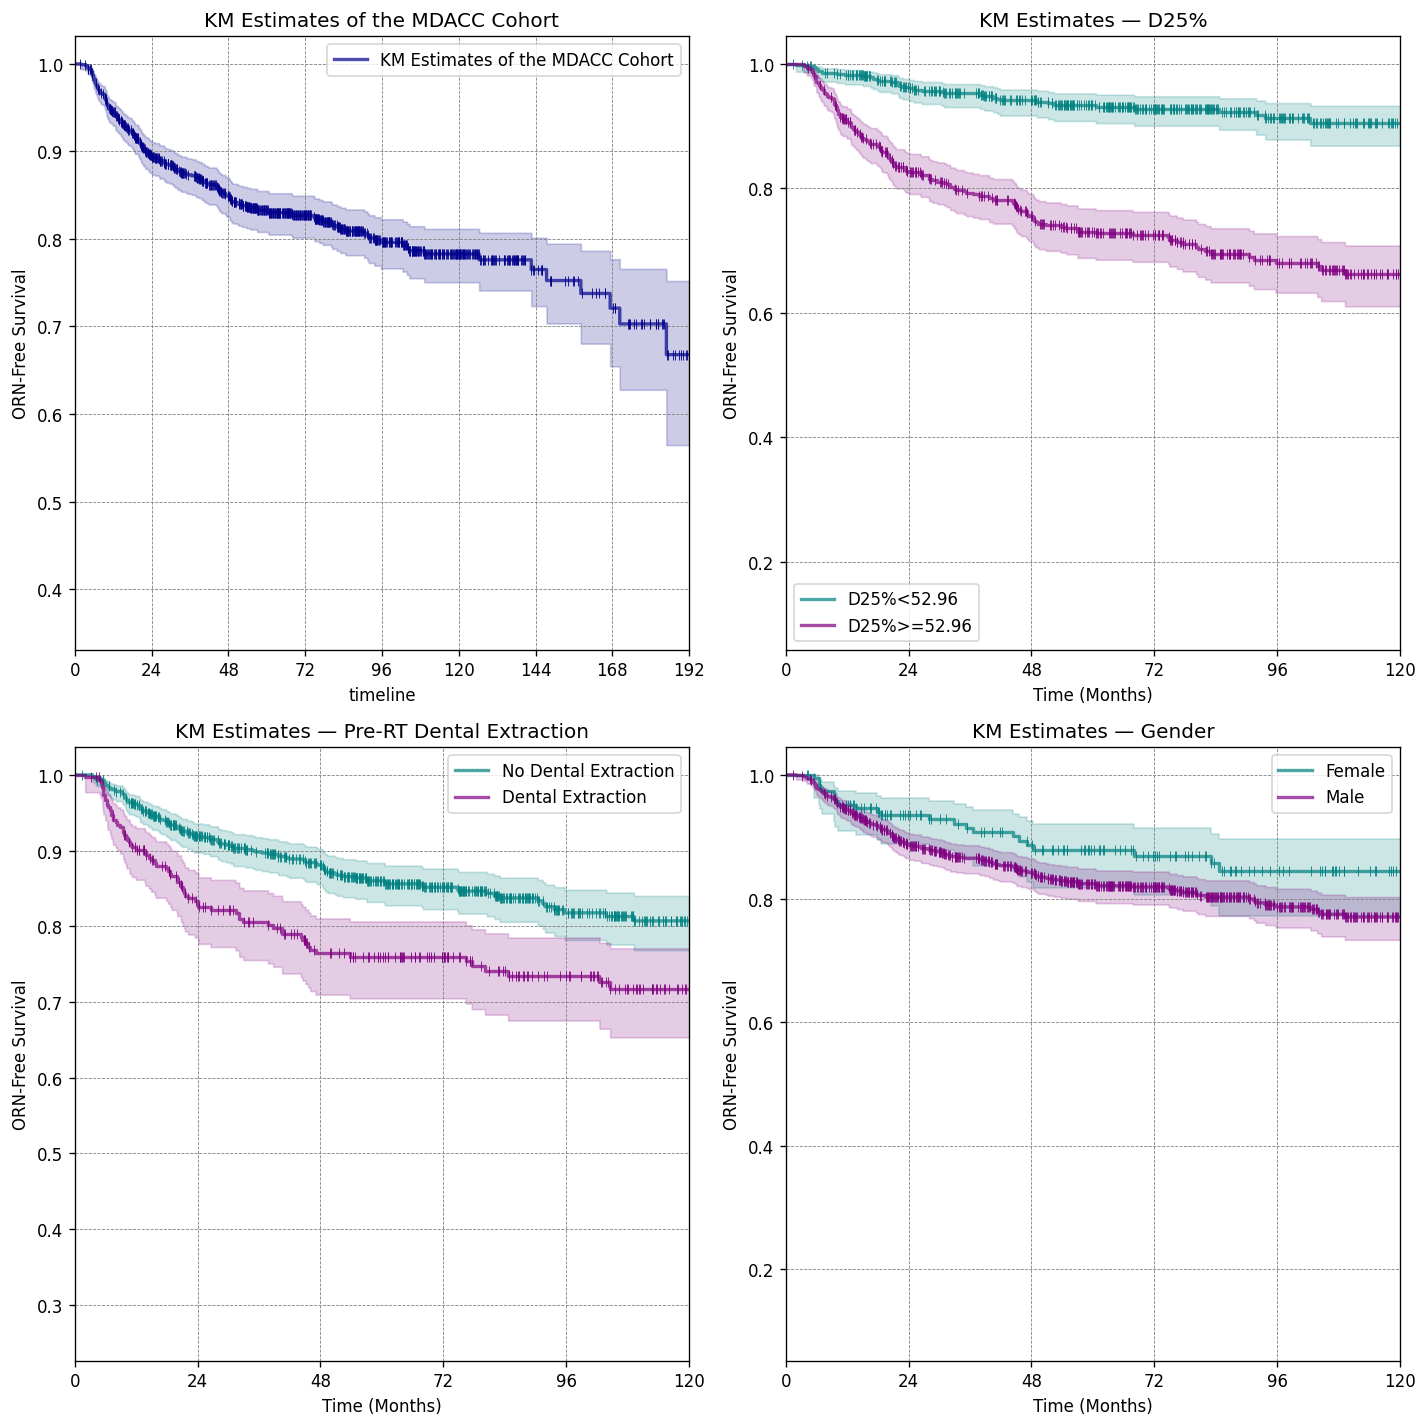

In [ ]:
# Kaplan-Meier plots
def plot_km(ax, data, condition, label, title, colors):
    kmf = KaplanMeierFitter()
    for i, c in enumerate(condition):
        kmf.fit(data.loc[c, 'Time to event'], data.loc[c, 'ORN status'], label=f'{label[i]}')
        kmf.plot(ax=ax, ci_show=True, alpha=0.7, ci_alpha=0.2, linewidth=2, linestyle='-', color=colors[i], show_censors=True, censor_styles={'marker': '|', 'ms': 6, 'mew': 0.5})
    ax.set_title(title)
    ax.set_xlabel('Time (Months)')
    ax.set_ylabel('ORN-Free Survival')
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')
    ax.set_xlim([0, 120])  # Set xlim after plotting


data_kmf = model_data

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 12), dpi=120)
xticks = list(range(0, 214, 24))
for ax in [ax1, ax2, ax3, ax4]:
    ax.set_xlim([0, 120])
    ax.set_xticks(xticks)
    ax.set_xlabel('Time (Months)')
    ax.set_ylabel('ORN-Free Survival')
    ax.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')

# Plot for entire MDACC cohort
kmf_mdacc = KaplanMeierFitter()
kmf_mdacc.fit(data_kmf['Time to event'], data_kmf['ORN status'], label='KM Estimates of the MDACC Cohort')
kmf_mdacc.plot(ax=ax1, ci_show=True, alpha=0.7, ci_alpha=0.2, linewidth=2, linestyle='-', c='darkblue', show_censors=True, censor_styles={'marker': '|', 'ms': 6, 'mew': 0.5})
ax1.set_title('KM Estimates of the MDACC Cohort')
ax1.grid(True, which='major', linestyle='--', linewidth=0.5, color='grey')

# Define colors for D25 plot
D25_colors = ['teal', 'purple']

# Define colors for dental extraction plot
dental_colors = ['teal', 'purple']

# Define colors for Gender plot
smoking_colors = ['teal', 'purple']

plot_km(ax2, data_kmf, [data_kmf['D25%'] < data_kmf['D25%'].median(), data_kmf['D25%'] >= data_kmf['D25%'].median()],  [f"D25%<{data_kmf['D25%'].median()}", f"D25%>={data_kmf['D25%'].median()}"], 'KM Estimates — D25%', D25_colors)
plot_km(ax3, data_kmf, [data_kmf['Pre-RT dental extractions'] == 0, data_kmf['Pre-RT dental extractions'] == 1], ['No Dental Extraction', 'Dental Extraction'], 'KM Estimates — Pre-RT Dental Extraction', dental_colors)
plot_km(ax4, data_kmf, [data_kmf['Gender_binary'] == 0, data_kmf['Gender_binary'] == 1], ['Female', 'Male'], 'KM Estimates — Gender', smoking_colors)

plt.tight_layout()
plt.show()


# Option 1: WAFT Model Training on MD Anderson Training Dataset

## Train-Test Split

In [ ]:
# Split the data into train and test sets with stratification on 'ORN status'
train_data, test_data = train_test_split(model_data, test_size=0.2, random_state=42, stratify=model_data['ORN status'])


## Fit WAFT Model


In [ ]:
# Fit the Weibull AFT model only on the training data
aft = WeibullAFTFitter()
aft.fit(train_data, duration_col='Time to event', event_col='ORN status')

aft.print_summary()


<lifelines.WeibullAFTFitter: fitted with 903 total observations, 745 right-censored observations>
             duration col = 'Time to event'
                event col = 'ORN status'
   number of observations = 903
number of events observed = 158
           log-likelihood = -1029.82
         time fit was run = 2025-05-12 21:12:49 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
param   covariate                                                                                                                  
lambda_ D25%                      -0.12      0.88      0.01           -0.15           -0.10                0.86                0.91
        Gender_binary             -0.48      0.62      0.31           -1.08            0.11                0.34                1.12
        Pre-RT dental extractions -0.31      0.73      0.21           -0.71            0.10                0.49                1.10
        Intercept                 13.69  8.85e+05      0.98           11.77           15.62            1.29e+05            6.08e+06
rho_    Intercept                 -0.21      0.81      0.07           -0.35           -0.08                0.71                0.93

                                   cmp to     z      p  -log2(p)
param   covariate                                               
lambda_ D25%                         0.00 -8.45 <0.005     54.96
        Gender_binary                0.00 -1.58   0.11      3.14
        Pre-RT dental extractions    0.00 -1.50   0.13      2.89
        Intercept                    0.00 13.92 <0.005    143.96
rho_    Intercept                    0.00 -3.06 <0.005      8.84
---
Concordance = 0.74
AIC = 2069.64
log-likelihood ratio test = 125.68 on 3 df
-log2(p) of ll-ratio test = 87.49

# Option 2: Load Trained MD Anderson WAFT Model for Inference

In [ ]:
with open(model_file, "rb") as f:
    aft = pickle.load(f)

# Visualize Model Parameters - Forest Plot

                                   95% lower-bound  95% upper-bound
param   covariate                                                  
lambda_ D25%                             -0.151525        -0.000576
        D25_grouped                      -0.122591         0.023935
        Gender_binary                    -1.103572         0.095041
        Pre-RT dental extractions        -0.701785         0.108037
        Intercept                        11.843992        15.713605
rho_    Intercept                        -0.345615        -0.074942


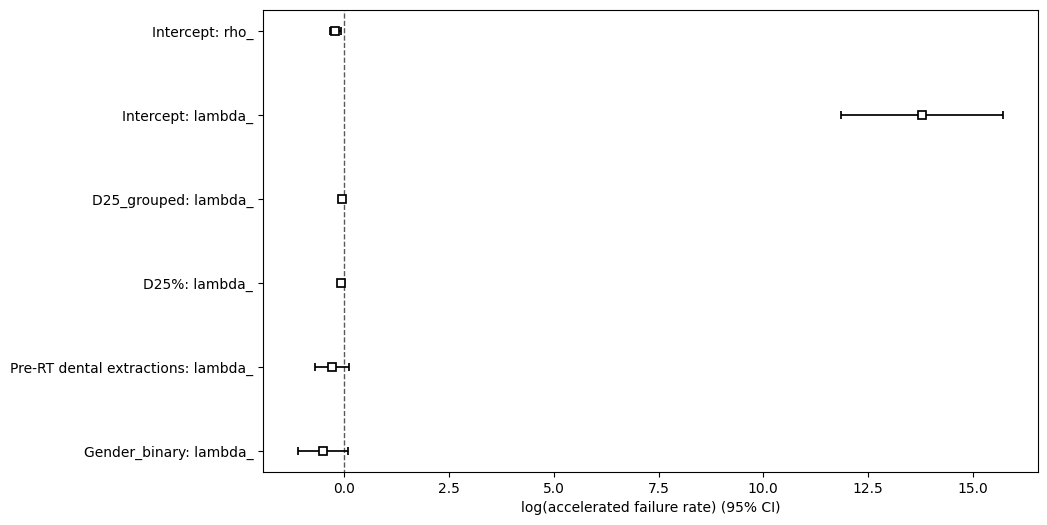

In [ ]:
# Forest plot

# Extract the confidence intervals
confidence_intervals = aft.confidence_intervals_
print(confidence_intervals)

# Create a forest plot
plt.figure(figsize=(10, 6))
aft.plot()
#plt.title('Weibull AFT Model Parameters')
plt.show()

# WAFT ORN-free Survival Curves

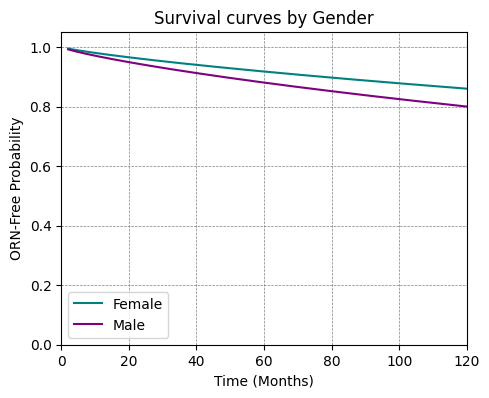

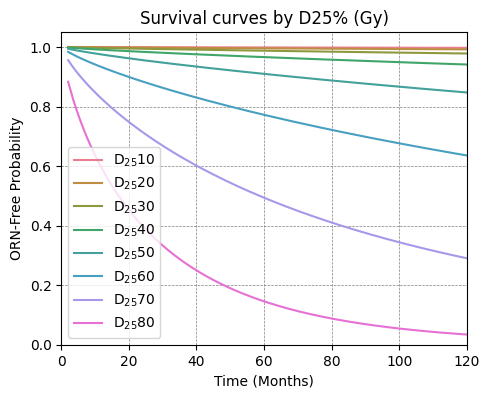

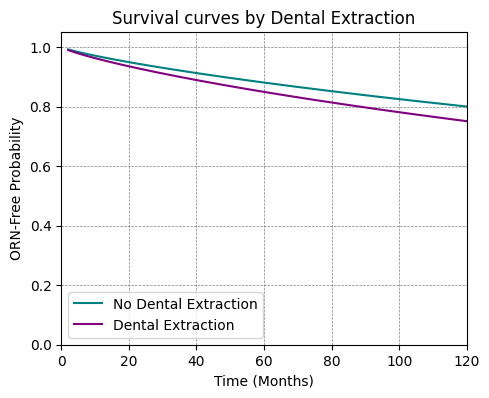

In [ ]:

def plot_survival_curves(ax, aft, feature, values, labels, title, color_palette=None, cmap=None):
    if color_palette is None:
        color_palette = sns.color_palette('husl', len(values))
    for value, label, color in zip(values, labels, color_palette):
        aft.plot_partial_effects_on_outcome(feature, [value], ax=ax, plot_baseline=False, color=color)
    ax.set_title(title)
    ax.set_xlabel('Time (Months)')
    ax.set_ylabel('ORN-Free Probability')
    ax.set_xlim([0, 120])  # Adjust the x-axis limit as needed
    ax.set_ylim([0, 1.05])  # Optionally adjust the y-axis limit if needed
    ax.legend(labels=labels)  # Assigning labels to the legend
    ax.grid(True, linestyle='--', linewidth=0.5, color='grey')

# Define the original color palette
colors_D25 = sns.color_palette('husl', 8, 0.8)
colors=[ 'teal','purple']

figsize = (5, 5)

# First plot - gender
plt.figure(figsize=figsize)
ax1 = plt.gca()
plot_survival_curves(ax1, aft, 'Gender_binary', [0, 1], ['Female', 'Male'], 'Survival curves by Gender', color_palette=colors)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Increase space for risk table

# Second plot - D25
plt.figure(figsize=figsize)
ax2 = plt.gca()
plot_survival_curves(ax2, aft, 'D25%', [10, 20, 30, 40, 50, 60, 70, 80], ["D$_{25}$10", 'D$_{25}$20', 'D$_{25}$30', 'D$_{25}$40', 'D$_{25}$50', 'D$_{25}$60', 'D$_{25}$70', 'D$_{25}$80'], 'Survival curves by D25% (Gy)', color_palette=colors_D25)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust space between plots

# Third plot - extractions
plt.figure(figsize=figsize)
ax3 = plt.gca()
plot_survival_curves(ax3, aft, 'Pre-RT dental extractions', [0, 1], ['No Dental Extraction', 'Dental Extraction'], 'Survival curves by Dental Extraction', color_palette=colors)
plt.tight_layout()
plt.subplots_adjust(bottom=0.3)  # Adjust space between plots

plt.show()

## At risk numbers tables

In [ ]:
# At risk numbers tables


def compute_at_risk_counts(data, time_col, group_col, time_points):
    """ Computes the number of individuals at risk at given time points. """
    at_risk = {t: data[data[time_col] >= t].groupby(group_col).size() for t in time_points}
    at_risk_df = pd.DataFrame(at_risk).T.fillna(0).astype(int)  # Convert to DataFrame for better handling
    return at_risk_df

# Define time points for risk table
time_points = [0, 20, 40, 60, 80, 100, 120]

# Compute numbers at risk
at_risk_gender = compute_at_risk_counts(train_data, 'Time to event', 'Gender_binary', time_points)
at_risk_dental = compute_at_risk_counts(train_data, 'Time to event', 'Pre-RT dental extractions', time_points)
#at_risk_d25 = compute_at_risk_counts(train_data, 'Time to event', 'D25%', time_points)

print("\nNumbers at Risk - Gender")
print(at_risk_gender.to_string(index=True))  # Ensures full table is printed

print("\nNumbers at Risk - Dental Extractions")
print(at_risk_dental.to_string(index=True))

#print("\nNumbers at Risk - D25%")
#print(at_risk_d25.to_string(index=True))

# D25%
# Define bins and labels
bins = [0, 15, 25, 35, 45, 55, 65, 75, 85]  # Define bin edges
labels = [10, 20, 30, 40, 50, 60, 70, 80]  # Labels for bins

# Create a new column in the dataset that categorizes `D25%` into bins
train_data['D25_grouped'] = pd.cut(train_data['D25%'], bins=bins, labels=labels, right=False)
test_data['D25_grouped'] = pd.cut(test_data['D25%'], bins=bins, labels=labels, right=False)

# Compute numbers at risk using the grouped D25% values
at_risk_d25_grouped = compute_at_risk_counts(train_data, 'Time to event', 'D25_grouped', time_points)

# Print results
print("\nNumbers at Risk - Grouped D25%")
print(at_risk_d25_grouped.to_string(index=True))


Numbers at Risk - Gender
Gender_binary    0    1
0              149  754
20             118  628
40              99  518
60              82  398
80              62  267
100             44  178
120             27   95

Numbers at Risk - Dental Extractions
Pre-RT dental extractions    0    1
0                          655  248
20                         550  196
40                         453  164
60                         349  131
80                         232   97
100                        147   75
120                         86   36

Numbers at Risk - Grouped D25%
D25_grouped  10  20  30   40   50   60  70  80
0            41  19  31  119  312  307  74   0
20           33  12  27  109  288  238  39   0
40           29  11  22   89  245  198  23   0
60           22  11  17   71  195  145  19   0
80           15   7  12   37  146  100  12   0
100          10   5   7   21  101   70   8   0
120           8   3   3   15   55   34   4   0


<ipython-input-44-992d2b758351>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  at_risk = {t: data[data[time_col] >= t].groupby(group_col).size() for t in time_points}
<ipython-input-44-992d2b758351>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  at_risk = {t: data[data[time_col] >= t].groupby(group_col).size() for t in time_points}
<ipython-input-44-992d2b758351>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  at_ri

In [ ]:
# Print AIC and BIC values
print(f"AIC: {aft.AIC_}")
print(f"BIC: {aft.BIC_}")

AIC: 2069.6367930161196
BIC: 2073.2482381229534


# Model Performance Evaluation on Test Subset
The code below assumes using the MD Anderson test subset defined above.
For testing the model on a different dataset, please load the dataset in the same format as the MD Anderson dataset and assign it to the variable 'test_data'.

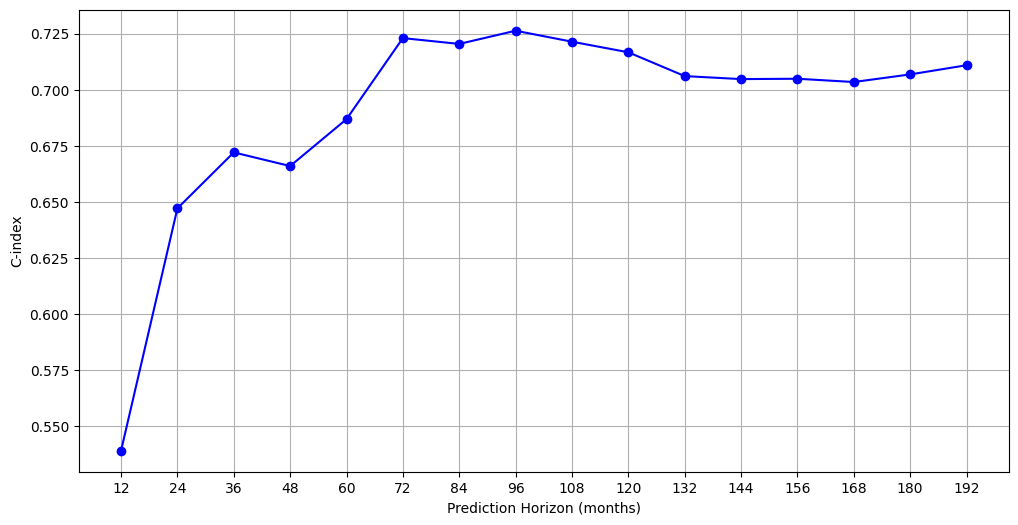

0.7263365468886941


In [ ]:
# C-Index across different prediction horizons on test subset

# Define the prediction horizons (in months)
prediction_horizons = np.arange(12, 197, 12)

c_indices_test = []

for horizon in prediction_horizons:
    test_data_horizon = test_data[test_data['Time to event'] <= horizon].copy()
    predicted_survival_times = aft.predict_percentile(test_data_horizon, p=0.5)
    c_index = concordance_index(test_data_horizon['Time to event'], predicted_survival_times, test_data_horizon['ORN status'])
    c_indices_test.append(c_index)

# Plot C-index for test_data
plt.figure(figsize=(12, 6))
plt.plot(prediction_horizons, c_indices_test, marker='o', color='blue', label='Test Data')
plt.xlabel('Prediction Horizon (months)')
plt.ylabel('C-index')
#plt.title('Harrells C-index over Different Prediction Horizons on Held Out Dataset')
plt.xticks(prediction_horizons)  # Set x-ticks to be the specified intervals
#plt.legend()
plt.grid(True)
plt.show()

print(np.max(c_indices_test))

## Model evaluation using the SurvivalEVAL function.
Individual Survival Distribution (ISD) models a patient's personalized survival probability at all future time points.
LifelinesEvaluator function takes the ISD curves, the time and censoring status of the test data, and the time and censoring status of the training data as inputs.

In [ ]:
isd_curves  = aft.fit(train_data, duration_col="Time to event", event_col="orn_status").predict_survival_function(test_data)
isd_curves.tail() #The index of the dataframe is the time points, and the columns are the sample IDs

,707,570,67,900,766,165,847,805,44,856,546,869,823,115,709,343,722,1001,743,952,371,1124,653,358,576,488,1014,1020,503,906,88,820,991,800,925,432,851,181,78,770,287,1034,466,15,288,95,123,661,1015,350,835,490,954,1005,130,374,23,1067,1102,1003,955,640,459,1008,710,248,380,1012,1029,300,24,198,332,698,326,630,39,591,472,413,902,960,945,257,647,173,510,524,655,194,318,878,122,336,700,684,147,200,575,35,197,266,430,289,919,5,804,1061,708,210,615,972,959,260,947,231,612,596,638,206,976,764,329,299,658,711,1057,597,276,690,492,751,1047,725,422,706,577,383,102,395,16,899,628,119,62,898,924,1107,971,425,201,26,155,870,867,813,474,43,598,980,1051,912,32,554,242,622,760,705,111,386,163,868,1002,473,579,1119,227,247,897,1000,229,891,723,126,607,129,486,871,80,484,259,404,1068,584,461,1063,518,616,592,578,135,882,652,1125,1,998,169,956,967,153,950,73,109,1021,981,964,571,52,550,942,535,241,291,498,845,660
194.23,0.249410,0.632158,0.839758,0.855957,0.797412,0.470410,0.541815,0.990789,0.886833,0.831050,0.991342,0.859861,0.889943,0.485413,0.836934,0.648452,0.636429,0.997701,0.887814,0.770964,0.887683,0.975370,0.723645,0.816090,0.813926,0.663344,0.523893,0.919712,0.918422,0.938877,0.582748,0.912751,0.147078,0.773347,0.912648,0.692430,0.191036,0.456492,0.523058,0.559829,0.884209,0.781623,0.804100,0.997729,0.764380,0.395170,0.890390,0.514589,0.782614,0.418842,0.601863,0.559502,0.790755,0.783204,0.788225,0.531791,0.957426,0.910936,0.581389,0.895316,0.803560,0.808804,0.869076,0.781267,0.530680,0.437640,0.711083,0.800945,0.929566,0.997573,0.686715,0.703231,0.514666,0.822127,0.875395,0.676440,0.919617,0.514589,0.224400,0.410826,0.888009,0.413078,0.444760,0.884008,0.378827,0.997604,0.448975,0.678878,0.603556,0.317819,0.861532,0.157139,0.535715,0.805286,0.755771,0.768402,0.553674,0.776347,0.481668,0.537362,0.997229,0.672512,0.198102,0.920749,0.896348,0.497462,0.892223,0.906706,0.569830,0.437945,0.974687,0.916356,0.962902,0.644978,0.804208,0.072070,0.478476,0.470191,0.544939,0.588926,0.490161,0.775056,0.551842,0.584878,0.186382,0.750375,0.752756,0.714384,0.520967,0.581597,0.487358,0.896106,0.892348,0.760895,0.769771,0.864432,0.488868,0.541671,0.728799,0.562686,0.754154,0.830861,0.477389,0.702343,0.990414,0.447948,0.237961,0.406236,0.767402,0.548541,0.554668,0.636075,0.508326,0.974392,0.638375,0.997687,0.595427,0.563284,0.829814,0.797412,0.717159,0.727233,0.484036,0.182156,0.908851,0.077812,0.663711,0.845154,0.214148,0.410293,0.132777,0.751436,0.575731,0.639434,0.784967,0.894704,0.385892,0.472376,0.936004,0.936725,0.995289,0.746903,0.997698,0.530549,0.567456,0.943772,0.968783,0.834339,0.868110,0.693840,0.621811,0.780834,0.899894,0.538945,0.401045,0.810595,0.816390,0.798964,0.282401,0.346689,0.669873,0.720695,0.557424,0.895132,0.507613,0.820239,0.497676,0.578078,0.920280,0.517745,0.815776,0.911390,0.737997,0.901021,0.162012,0.580806,0.446979,0.850533,0.380456,0.549007,0.739426,0.819027,0.510444,0.940284,0.913772,0.483249
197.80,0.244313,0.627862,0.837580,0.853979,0.794733,0.465164,0.536900,0.990652,0.885251,0.828767,0.991214,0.857933,0.888402,0.480225,0.834722,0.644289,0.632167,0.997667,0.886244,0.767988,0.886112,0.975008,0.720173,0.813628,0.811438,0.659308,0.518882,0.918568,0.917260,0.937997,0.578088,0.911513,0.142946,0.770397,0.911409,0.688657,0.186392,0.451200,0.518042,0.555021,0.882592,0.778765,0.801498,0.997695,0.761333,0.389752,0.888854,0.509531,0.779767,0.413457,0.597336,0.554692,0.788000,0.780364,0.785441,0.526821,0.956807,0.909673,0.576720,0.893845,0.800951,0.806256,0.867265,0.778404,0.525704,0.432296,0.707487,0.798306,0.928557,0.997537,0.682888,0.699560,0.509608,0.819736,0.873664,0.672520,0.918472,0.509531,0.219469,0.405428,0.886442,0.407683,0.439434,0.882389,0.373399,0.997568,0.443661,0.674979,0.599041,0.312448,0.859625,0.152874,0.530767,0.802697,0.752631,0.765398,0.548828,0.773431,0.476465,0.532423,0.997188,0.668556,0.193390,0.919620,0.894891,0.492324,0.890711,0.905387,0.565085,0.432601,0.974316,0.915167,0.962361,0.640786,0.801607,0.069306,

In [ ]:
# Initialize the evaluator
evl = LifelinesEvaluator(
    isd_curves,
    test_data["Time to event"],
    test_data["ORN status"],
    train_data["Time to event"],
    train_data["ORN status"]
)

# Concordance index
cindex , correct_pairs , total_pairs  = evl.concordance()
print(" Model - C-index: {:.3f}; \nNumber of correctly ordered pairs: {}; \nNumber of total comparable pairs: {}.".format(cindex , correct_pairs , total_pairs ))

# MAE
mae  = evl .mae(method="Hinge", weighted=False, log_scale=True)
print(" Model - Mean Log Absolute Error : {:.3f}.".format(mae ))
mse = evl.mse(method="Hinge", weighted=False, log_scale=True)
print("Mean Logarithmic Squared Error (MLSE) -Hinge: {:.3f}.".format(mse))

 Model - C-index: 0.714; 
Number of correctly ordered pairs: 4628.0; 
Number of total comparable pairs: 6481.0.
 Model - Mean Log Absolute Error : 0.413.
Mean Logarithmic Squared Error (MLSE) -Hinge: 1.158.


/usr/local/lib/python3.11/dist-packages/SurvivalEVAL/Evaluator.py:60: UserWarning: The first time coordinate is not 0. A authentic survival curve should start from 0 with 100% survival probability. Adding 0 to the beginning of the time coordinates and 1 to the beginning of the predicted curves.
  warnings.warn("The first time coordinate is not 0. A authentic survival curve should start from 0 "


(<Figure size 640x480 with 1 Axes>,
 <Axes: xlabel='Time', ylabel='Survival probability'>)

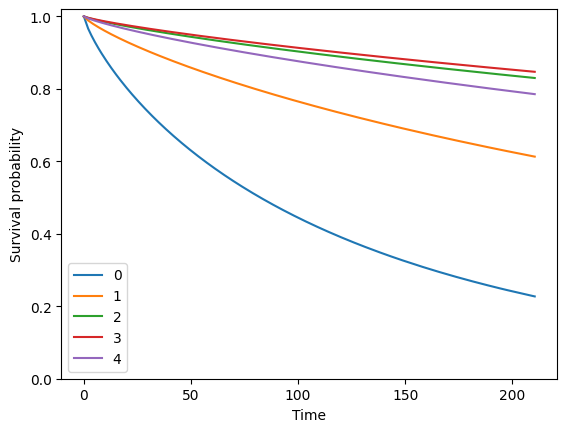

In [ ]:
evl.plot_survival_curves(curve_indices=[0, 1, 2, 3, 4])


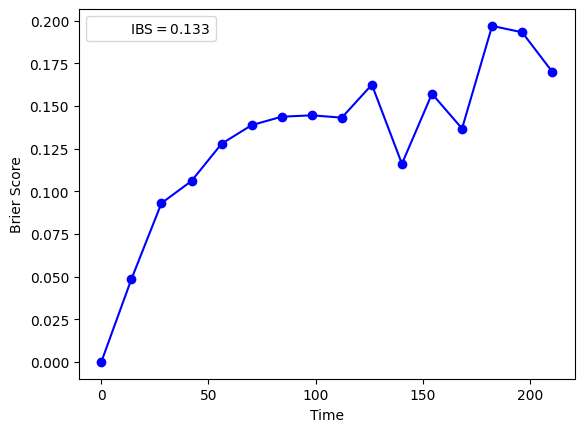

The model is d-calibrated!
0.9987490558834341


In [ ]:
#D-calibration

ibs  = evl.integrated_brier_score(num_points=16, draw_figure=True)
p_value, bin_hist  = evl.d_calibration(num_bins=10)


if p_value >= 0.05:
    print("The model is d-calibrated!")
else:
    print("The model is not d-calibrated!")


print(p_value)

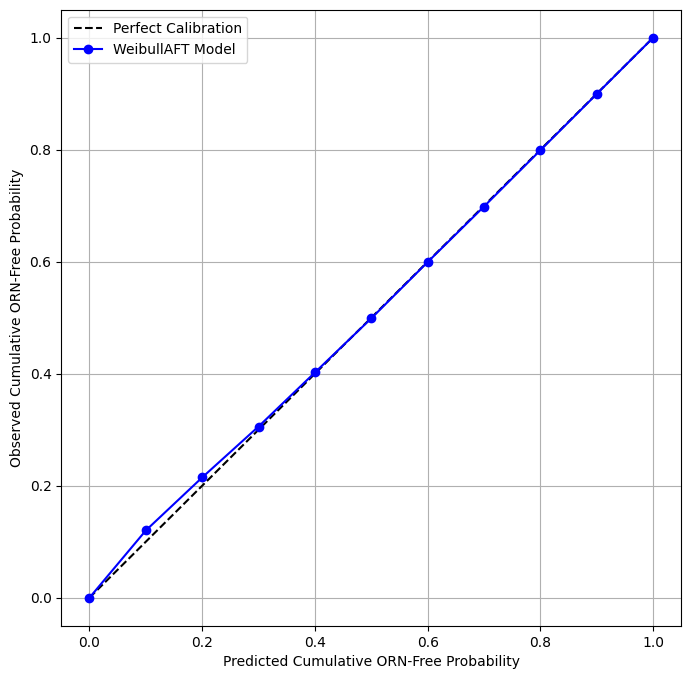

In [ ]:
# Distribution Calibration (D-calibration)

# Normalize the histograms
bin_hist  /= bin_hist .sum()

default = np.linspace(0, 1, 11)
plt.figure(figsize=(8, 8))  # Square figure

plt.plot(default, default, linestyle='dashed', label="Perfect Calibration", color='black')

# Calculate the cumulative fractions for plotting
fraction = np.concatenate((np.array([0]), bin_hist))
plt.plot(default, fraction.cumsum(), 'o-', label="WeibullAFT Model", color='blue')
plt.xlabel("Predicted Cumulative ORN-Free Probability")
plt.ylabel("Observed Cumulative ORN-Free Probability")
plt.legend()
plt.grid(True)

plt.show()



In [ ]:
# One-time Calibration - output: p-value of Hosmer-Lemeshow goodness-of-fit test at a target time

target_t = 72
auc = evl.auc(target_t)
bs = evl.brier_score(target_t)
p, ob, exp = evl.one_calibration(target_t)

print(p)

print("AUC: {:.4f}; \nBS: {:.4f}.".format(auc, bs))
if p >= 0.05:
    print("The model is 1-calibrated!")
else:
    print("The model is not 1-calibrated!")

0.11633894690080449
AUC: 0.6915; 
BS: 0.1392.
The model is 1-calibrated!


## Observed vs. Expected Survival Probability Plot

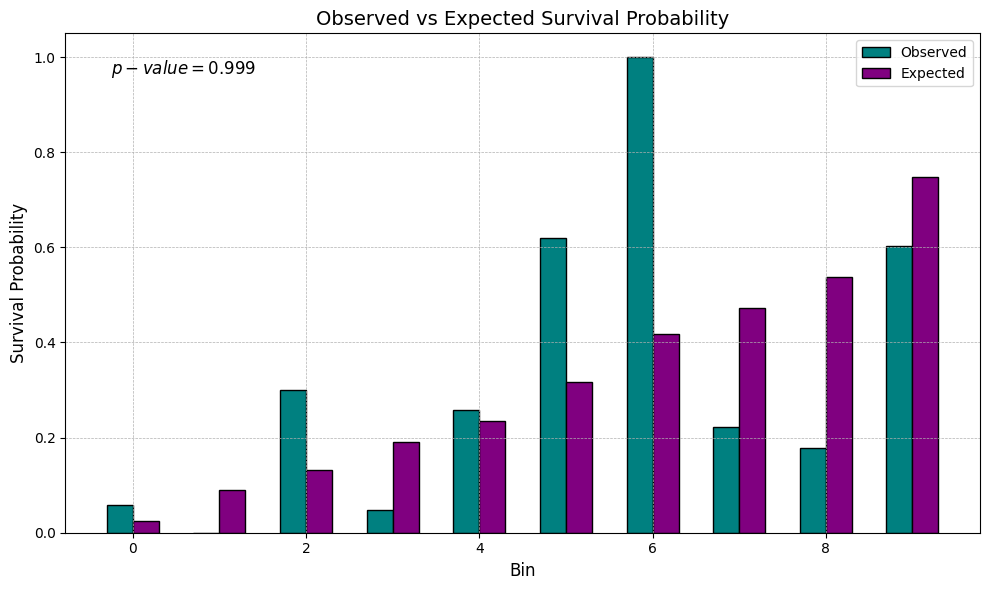

In [ ]:
# Reverse the lists
ob.reverse()
exp.reverse()

# Define bins
bins = np.arange(10)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot observed and expected values
plt.bar(bins - 0.15, ob, width=0.3, label="Observed", color='teal', edgecolor='black')
plt.bar(bins + 0.15, exp, width=0.3, label="Expected", color='purple', edgecolor='black')

plt.xlabel('Bin', fontsize=12)
plt.ylabel('Survival Probability', fontsize=12)
plt.title('Observed vs Expected Survival Probability', fontsize=14)

plt.text(0.05, 0.95, r'$p-value = {:.3f}$'.format(p_value), verticalalignment='top', horizontalalignment='left',
         fontsize=12, color='black', transform=plt.gca().transAxes)

plt.legend()

plt.grid(True,  linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()


## Model Performance Metrics Over Time

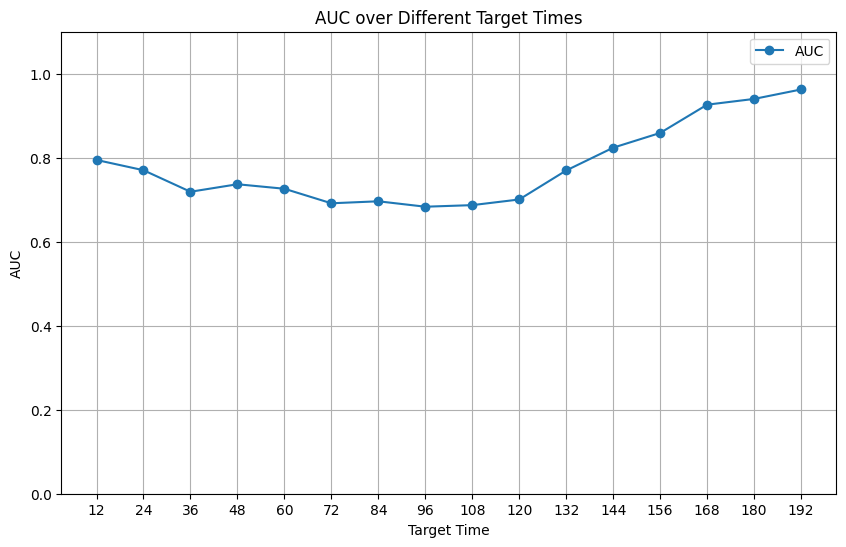

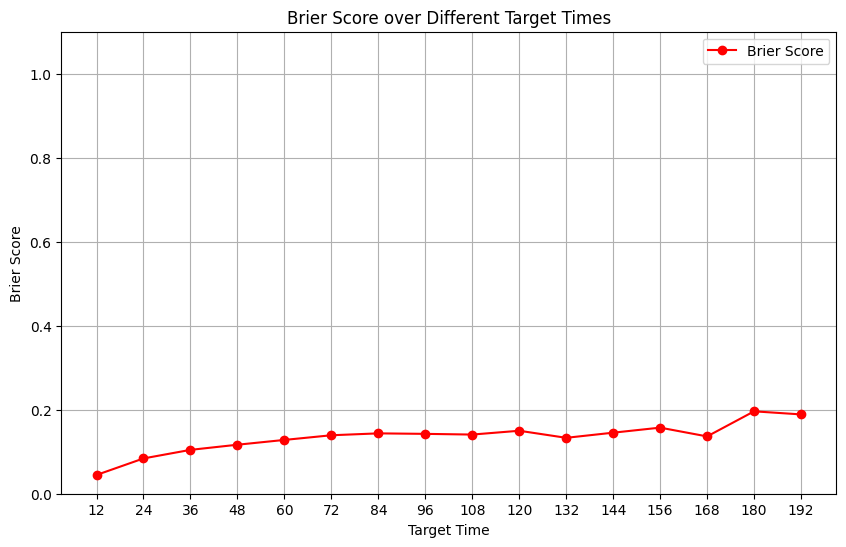

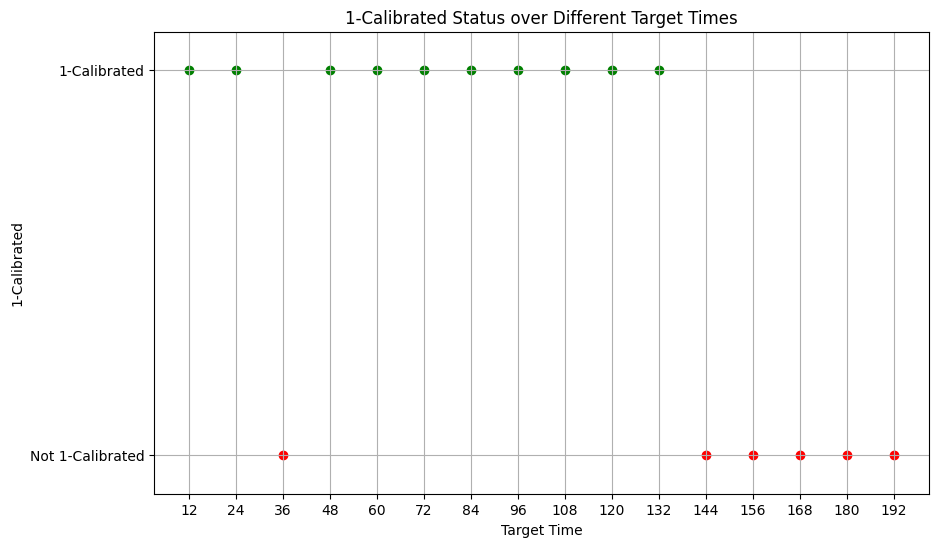

In [ ]:
# Define target times from 12 to 196 at intervals of 12
target_times = np.arange(12, 197, 12)

# Lists to store metric values
auc_values = []
brier_scores = []
calibration_status = []

# Iterate over target times
for target_t in target_times:
    target_time = int(target_t)  # Convert to regular Python integer
    auc = evl.auc(target_time)
    bs = evl.brier_score(target_time)
    p, ob, exp = evl.one_calibration(target_time)

    auc_values.append(auc)
    brier_scores.append(bs)
    calibration_status.append(p >= 0.05)


# Plot AUC values
plt.figure(figsize=(10, 6))
plt.plot(target_times, auc_values, marker='o', label='AUC')
plt.xlabel('Target Time')
plt.ylabel('AUC')
plt.title('AUC over Different Target Times')
plt.xticks(target_times)
plt.ylim(0, 1.1)

plt.grid(True)
plt.legend()
plt.show()

# Plot Brier scores
plt.figure(figsize=(10, 6))
plt.plot(target_times, brier_scores, marker='o', color='r', label='Brier Score')
plt.xlabel('Target Time')
plt.ylabel('Brier Score')
plt.ylim(0, 1.1)

plt.title('Brier Score over Different Target Times')
plt.xticks(target_times)
plt.grid(True)
plt.legend()
plt.show()

# Plot calibration status as dots
plt.figure(figsize=(10, 6))
for i, status in enumerate(calibration_status):
    color = 'g' if status else 'r'
    plt.scatter(target_times[i], 1 if status else 0, color=color)

plt.xlabel('Target Time')
plt.ylabel('1-Calibrated')
plt.title('1-Calibrated Status over Different Target Times')
plt.xticks(target_times)
plt.ylim(-0.1, 1.1)
plt.yticks([0, 1], ['Not 1-Calibrated', '1-Calibrated'])
plt.grid(True)
plt.show()